# BALSAC UMAP

The goal of this Jupyter notebook is to plot the UMAP projection of the kinship of all non-sibling probands who married in Saguenay–Lac-Saint-Jean between 1931 and 1960.

In [1]:
from collections import Counter
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Patch
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.covariance import EllipticEnvelope

The paths to the datasets are found in the *paths.json* file.

In [2]:
with open("../paths.json", 'r') as file:
    paths = json.load(file)

The following loads the UMAP projection of BALSAC probands.

In [3]:
with open(paths['wd'] + "results/pickles/balsac_umap.pkl", 'rb') as file:
    emb = pickle.load(file)
emb.shape

(26445, 2)

The following loads the list of BALSAC probands themselves.

In [4]:
with open(paths['wd'] + "results/pickles/balsac_pro_0.5_nosibs.pkl", 'rb') as file:
    inds = pickle.load(file)
len(inds)

26445

The following CSV contains all demographical information, such as location and year of marriage.

In [5]:
with open(paths['demography_information'], 'rb') as file:
    civil_df = pd.read_csv(file, sep=';', low_memory=False)

We extract the location of marriage of each of the probands' parents.

In [6]:
urbs_parents = civil_df.set_index('IndID').loc[inds].loc[:, 'URBMariageParents'].tolist()
urbs_parents = [0 if np.isnan(city) else int(city) for city in urbs_parents]
urbs_parents[:10]

[2895, 3001, 2769, 3617, 3172, 2871, 2853, 2804, 2804, 2765]

For the parents' location of marriage, each municipality code is converted to a human-readable name string.

In [7]:
with open(paths['geography_definitions']) as file:
    definition_df = pd.read_csv(file)
urbs_parents_df = pd.DataFrame({'UrbIdMariage': urbs_parents})
unknown_row = pd.DataFrame({'UrbIdMariage': [0], 'RegionMariage': ['Inconnue'], 'UrbMariage': ['Inconnue']})
definition_with_unknown_df = pd.concat([definition_df, unknown_row], ignore_index=True)
result = urbs_parents_df.merge(definition_with_unknown_df[['UrbIdMariage', 'UrbMariage']], on='UrbIdMariage', how='left')
cities_parents = result['UrbMariage'].tolist()

Each municipality within Charlevoix and Saguenay–Lac-Saint-Jean is assigned a watercourse subdivision.

In [8]:
city_to_water_boundary = {
    "Albanel": "Ashuapmushuan-Mistassini",
    "Alma": "East of Lac Saint-Jean",
    "Arvida": "South of Saguenay River",
    "Bégin": "North of Saguenay River",
    "Chambord": "Métabetchouane-Ashuapmushuan",
    "Chicoutimi": "South of Saguenay River",
    "Chicoutimi-Nord": "North of Saguenay River",
    "Chute-des-Passes": "Mistassini-Péribonka",
    "Delisle": "East of Lac Saint-Jean",
    "Desbiens": "La-Belle-Rivière–Métabetchouane",
    "Dolbeau": "Ashuapmushuan-Mistassini",
    "Ferland-et-Boilleau": "South of Saguenay River",
    "Girardville": "Ashuapmushuan-Mistassini",
    "Hébertville": "East of Lac Saint-Jean",
    "Hébertville-Station": "East of Lac Saint-Jean",
    "Jonquière": "South of Saguenay River",
    "L'Anse-Saint-Jean": "East of Ha! Ha!",
    "L'Ascension-de-Notre-Seigneur": "East of Lac Saint-Jean",
    "La Baie": "South of Saguenay River",
    "La Doré": "Métabetchouane-Ashuapmushuan",
    "Labrecque": "East of Lac Saint-Jean",
    "Lac-Bouchette": "Métabetchouane-Ashuapmushuan",
    "Lac-Kénogami": "South of Saguenay River",
    "Lac-à-la-Croix": "La-Belle-Rivière–Métabetchouane",
    "Larouche": "South of Saguenay River",
    "Laterrière": "South of Saguenay River",
    "Mashteuiatsh": "Métabetchouane-Ashuapmushuan",
    "Mistassini": "Mistassini-Péribonka",
    "Métabetchouan": "La-Belle-Rivière–Métabetchouane",
    "Mont-Apica": "East of Lac Saint-Jean",
    "Normandin": "Ashuapmushuan-Mistassini",
    "Notre-Dame-de-Lorette": "Mistassini-Péribonka",
    "Notre-Dame-du-Rosaire": "East of Lac Saint-Jean",
    "Petit-Saguenay": "East of Ha! Ha!",
    "Péribonka": "Mistassini-Péribonka",
    "Rivière-Éternité": "East of Ha! Ha!",
    "Roberval": "Métabetchouane-Ashuapmushuan",
    "Saint-Ambroise": "North of Saguenay River",
    "Saint-André-du-Lac-Saint-Jean": "La-Belle-Rivière–Métabetchouane",
    "Saint-Augustin-du-Lac-Saint-Jean": "Mistassini-Péribonka",
    "Saint-Bruno": "East of Lac Saint-Jean",
    "Saint-Charles-de-Bourget": "North of Saguenay River",
    "Saint-David-de-Falardeau": "North of Saguenay River",
    "Saint-Edmond": "Ashuapmushuan-Mistassini",
    "Saint-Eugène-du-Lac-Saint-Jean": "Mistassini-Péribonka",
    "Saint-François-de-Sales": "Métabetchouane-Ashuapmushuan",
    "Saint-Fulgence": "North of Saguenay River",
    "Saint-Félicien": "Métabetchouane-Ashuapmushuan",
    "Saint-Félix-d'Otis": "East of Ha! Ha!",
    "Saint-Gédéon": "East of Lac Saint-Jean",
    "Saint-Henri-de-Taillon": "East of Lac Saint-Jean",
    "Saint-Honoré-de-Chicoutimi": "North of Saguenay River",
    "Saint-Ludger-de-Milot": "Mistassini-Péribonka",
    "Saint-Méthode": "Ashuapmushuan-Mistassini",
    "Saint-Nazaire": "East of Lac Saint-Jean",
    "Saint-Prime": "Ashuapmushuan-Mistassini",
    "Saint-Stanislas-du-Lac-Saint-Jean": "Mistassini-Péribonka",
    "Saint-Thomas-Didyme": "Ashuapmushuan-Mistassini",
    "Sainte-Hedwidge": "Métabetchouane-Ashuapmushuan",
    "Sainte-Jeanne-d'Arc-du-Lac-Saint-Jean": "Mistassini-Péribonka",
    "Sainte-Monique-de-Honfleur": "East of Lac Saint-Jean",
    "Sainte-Rose-du-Nord": "North of Saguenay River",
    "Sainte-Élisabeth-de-Proulx": "Mistassini-Péribonka",
    "Shipshaw": "North of Saguenay River",
    "Val-Jalbert": "Métabetchouane-Ashuapmushuan",
    'Baie-Sainte-Catherine': 'Charlevoix',
    'Baie-Saint-Paul': 'Charlevoix',
    "Cap A L'aigle": 'Charlevoix',
    'Clermont': 'Charlevoix',
    'La Malbaie': 'Charlevoix',
    'Les Éboulements': 'Charlevoix',
    'Notre Dame Des Monts': 'Charlevoix',
    'Petite-Rivière-Saint-François': 'Charlevoix',
    'Pointe-au-Pic': 'Charlevoix',
    'St Aime Des Lacs': 'Charlevoix',
    "Saint-Bernard-de-l'Isle-aux-Coudres": 'Charlevoix',
    'Sainte-Agnès': 'Charlevoix',
    'Saint-Fidèle-de-Mont-Murray': 'Charlevoix',
    'Saint-Hilarion': 'Charlevoix',
    'Saint-Irénée': 'Charlevoix',
    'Saint-Joseph-de-la-Rive': 'Charlevoix',
    "Saint-Louis-de-l'Isle-aux-Coudres": 'Charlevoix',
    'Saint-Siméon': 'Charlevoix',
    'Saint-Urbain-de-Charlevoix': 'Charlevoix'
}

The parents' location of marriage is converted to its corresponding watercourse subdivision.

In [9]:
boundaries_parents = [city_to_water_boundary.get(city, 'Outside Charlevoix/SLSJ or unknown') for city in cities_parents]
boundaries_counts = Counter(boundaries_parents)
boundaries_counts

Counter({'Outside Charlevoix/SLSJ or unknown': 6700,
         'South of Saguenay River': 6597,
         'East of Lac Saint-Jean': 3493,
         'Métabetchouane-Ashuapmushuan': 2735,
         'North of Saguenay River': 1897,
         'Ashuapmushuan-Mistassini': 1650,
         'Charlevoix': 1047,
         'La-Belle-Rivière–Métabetchouane': 1045,
         'Mistassini-Péribonka': 791,
         'East of Ha! Ha!': 490})

Each subdivision is attributed a colour.

In [10]:
subdivision_to_colour = {
    "Charlevoix": 'orangered',
    "East of Ha! Ha!": 'gold',
    "South of Saguenay River": 'lime',
    "East of Lac Saint-Jean": 'darkgreen',
    "La-Belle-Rivière–Métabetchouane": 'aqua',
    "Métabetchouane-Ashuapmushuan": 'dodgerblue',
    "Ashuapmushuan-Mistassini": '#a020f0',
    "Mistassini-Péribonka": 'rosybrown',
    "North of Saguenay River": 'deeppink',
    "Outside Charlevoix/SLSJ or unknown": 'gainsboro'
}
boundaries_colors = [subdivision_to_colour[boundaries] for boundaries in boundaries_parents]
boundaries_colors[:10]

['dodgerblue',
 'gainsboro',
 'orangered',
 'gainsboro',
 'gainsboro',
 'darkgreen',
 'dodgerblue',
 'lime',
 'lime',
 'lime']

Now, let's plot Figure 3 of the article.

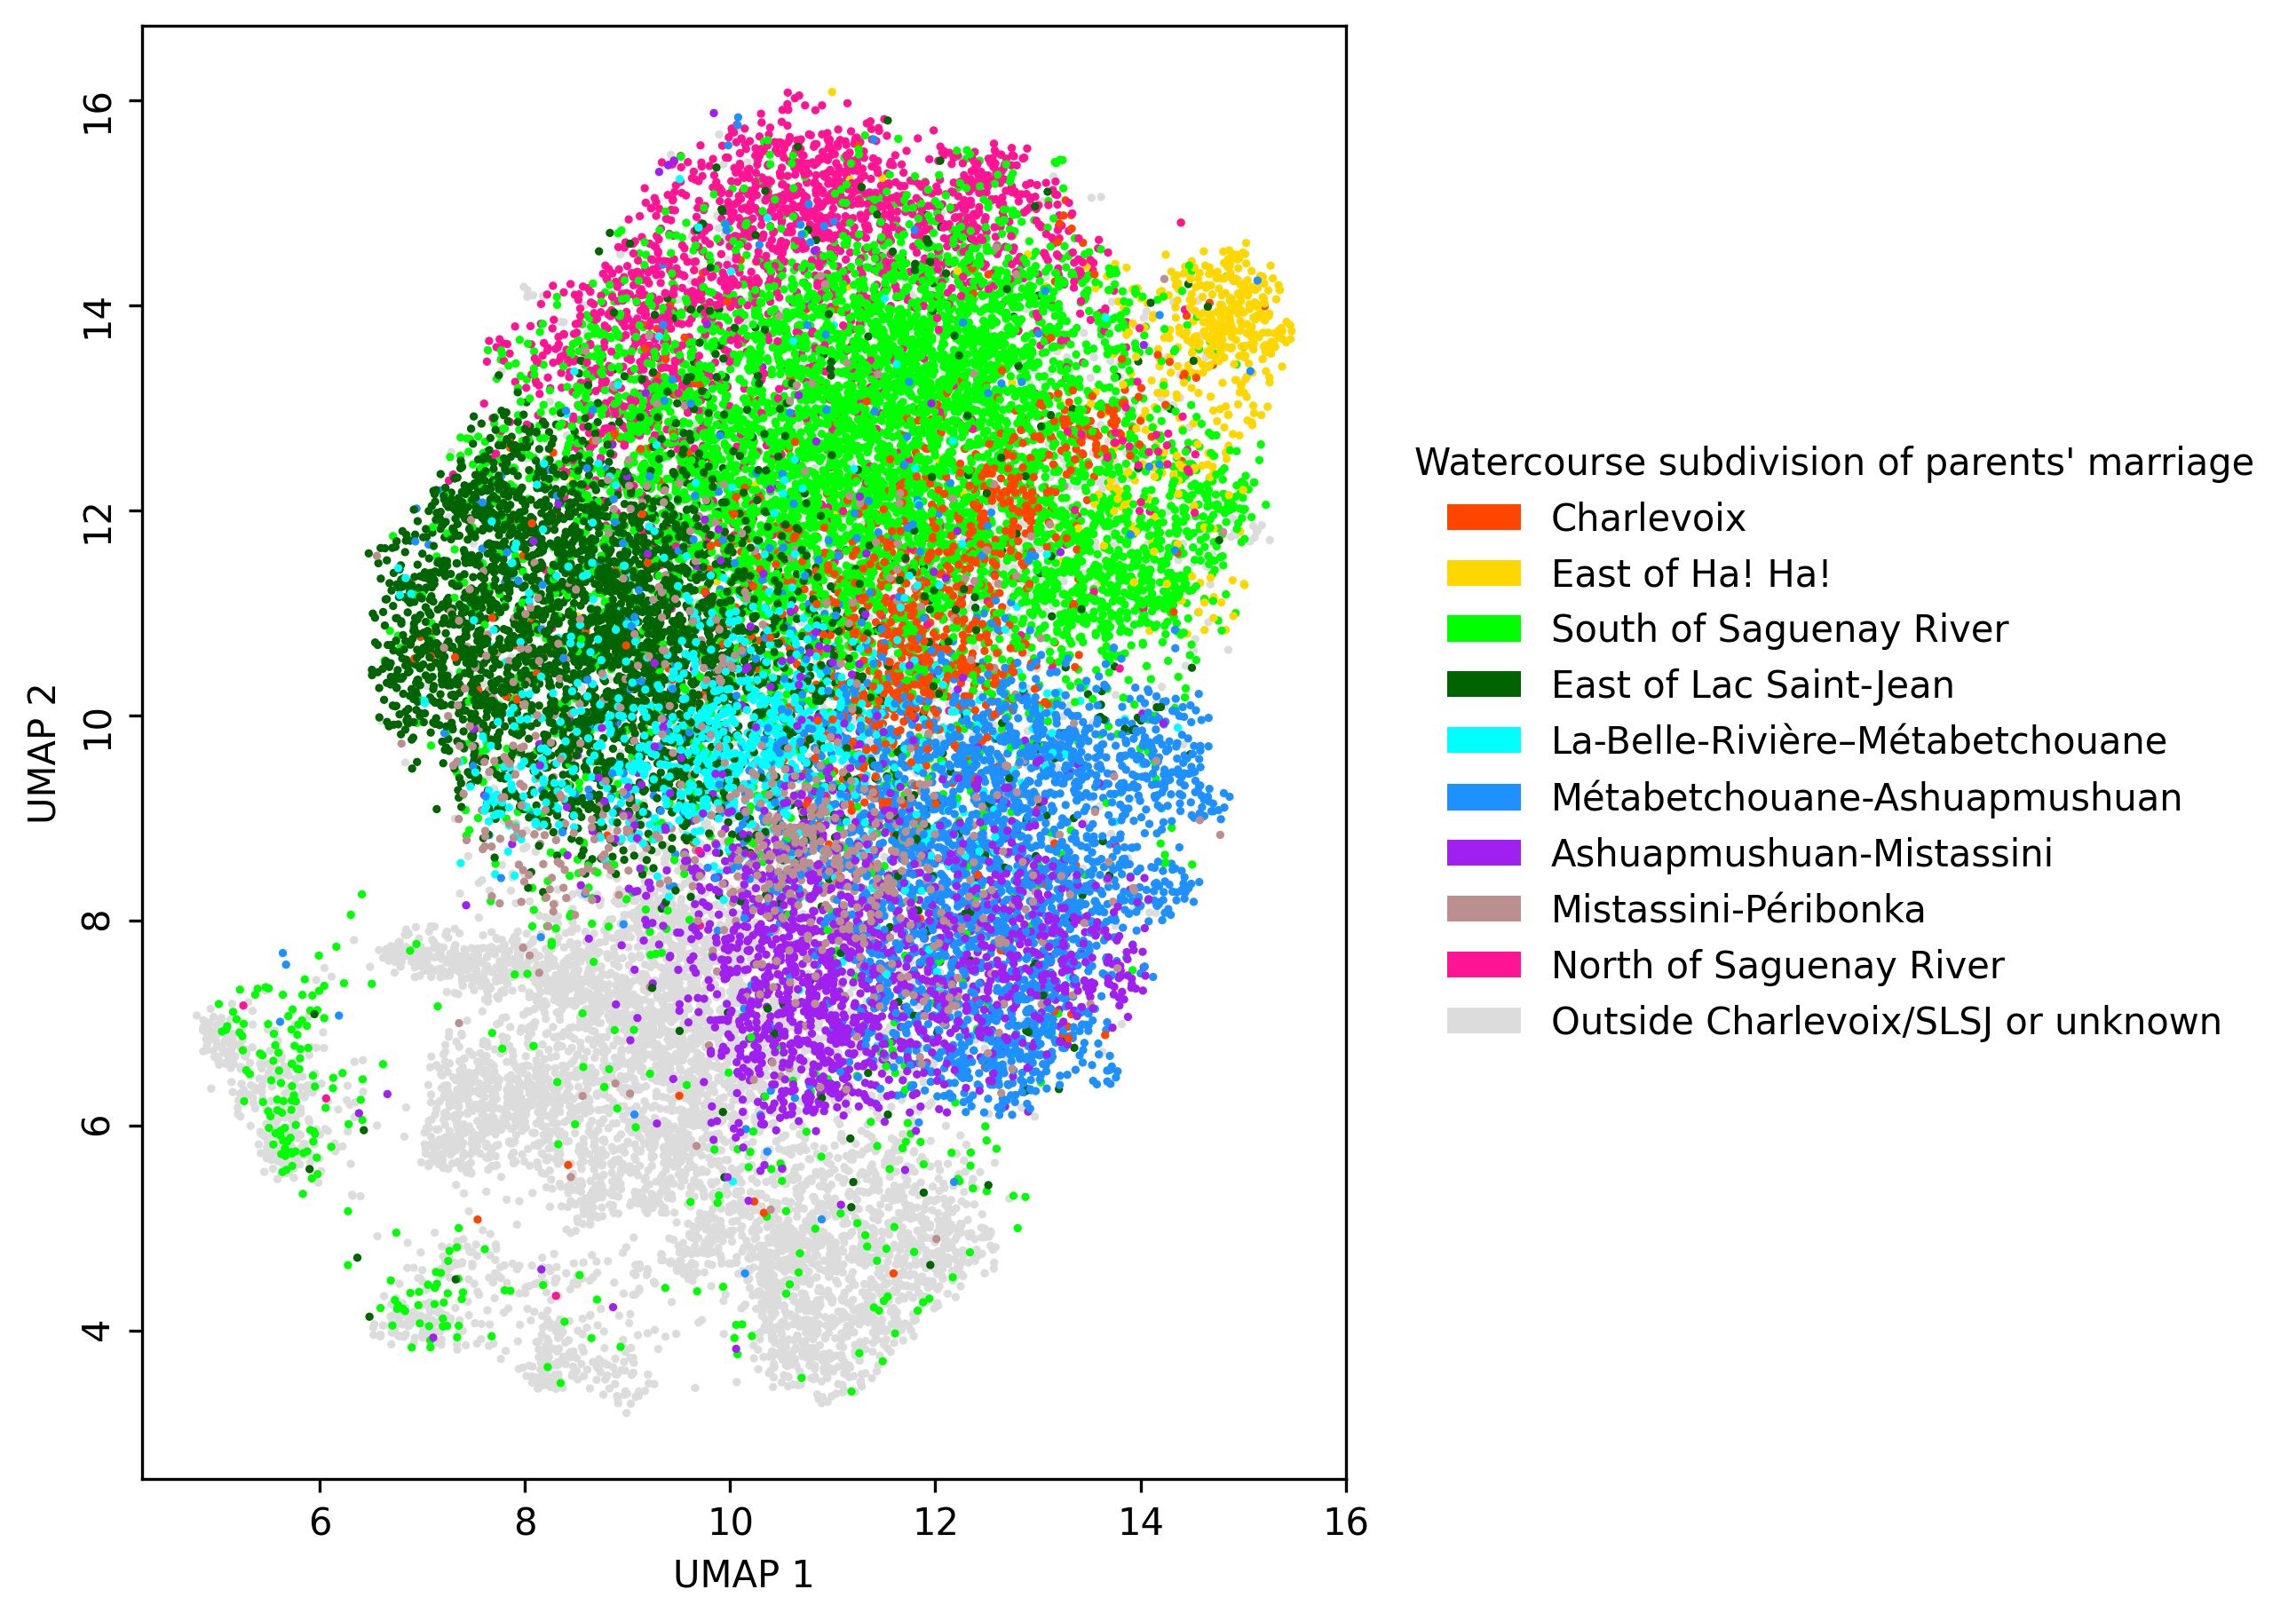

In [11]:
fig, ax = plt.subplots(figsize=(180/25.4, 180/25.4), dpi=300)

# Calculate indices for the two groups
gray = [index for index, boundary in enumerate(boundaries_parents)
        if boundary == 'Outside Charlevoix/SLSJ or unknown']
filter = [index for index, boundary in enumerate(boundaries_parents)
          if boundary != 'Outside Charlevoix/SLSJ or unknown']

# Plot the two groups using seaborn's scatterplot
sns.scatterplot(
    x=emb[:, 0][gray],
    y=emb[:, 1][gray],
    color='gainsboro',
    edgecolor='none',
    s=5,
    ax=ax)

sns.scatterplot(
    x=emb[:, 0][filter],
    y=emb[:, 1][filter],
    hue=[boundary for boundary in boundaries_parents if boundary != "Outside Charlevoix/SLSJ or unknown"],
    palette=subdivision_to_colour,
    edgecolor='none',
    s=5,
    ax=ax)

# Label axes
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

# Rotate y-axis labels
for label in ax.get_yticklabels():
    label.set_rotation(90)

# Remove the automatic legend from the scatterplots
legend = ax.get_legend()
if legend is not None:
    legend.remove()

# Create custom legend elements
legend_elements = [Patch(facecolor=color, label=water_boundary)
                   for water_boundary, color in subdivision_to_colour.items()]

# Place the legend outside the plot (to the right)
legend_handle = fig.legend(handles=legend_elements, bbox_to_anchor=(0.85, 0.5),
                           loc='center left', frameon=False)
legend_handle.set_title("Watercourse subdivision of parents' marriage")

# Set the aspect ratio to equal so that the plot is square in data space
ax.set_aspect('equal', adjustable='box')

plt.savefig(paths['wd'] + "results/figures/3.BALSACUMAP.svg", bbox_inches='tight')

plt.show()

The following function, used to plot confidence ellipses, comes from [this webpage](https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html).

In [12]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Finally, let's plot Supplementary Figure 5.

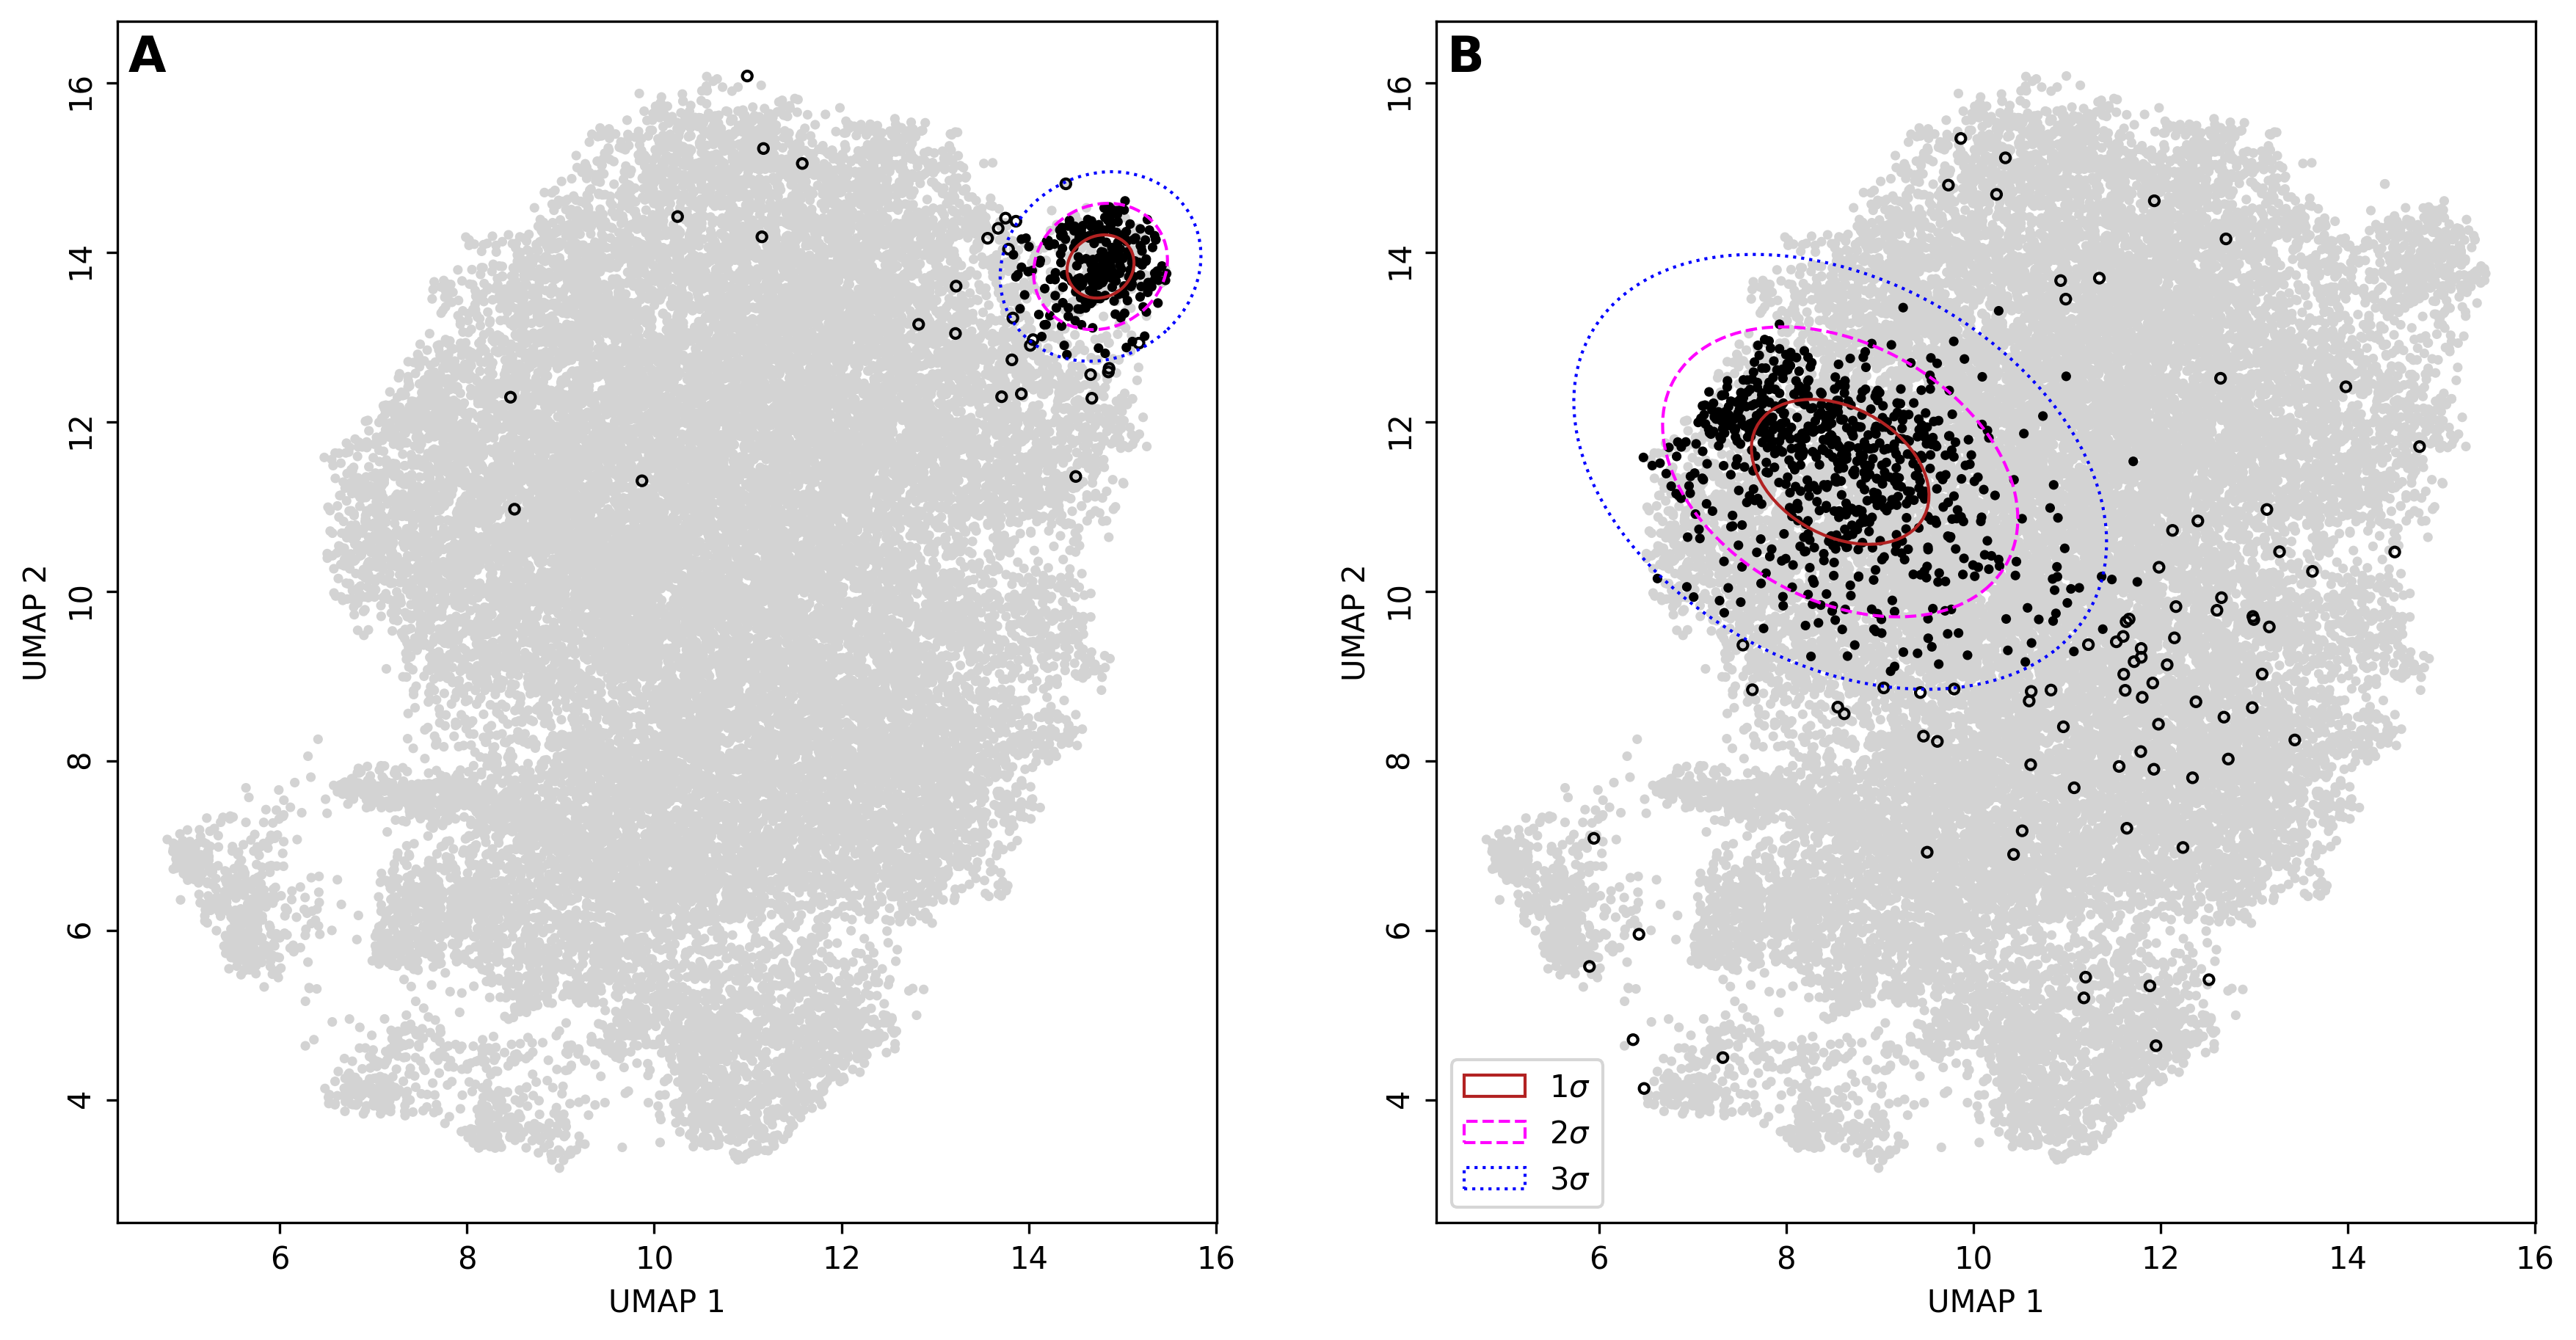

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(180*2/25.4, 90*2/25.4), dpi=300)

gray = [index for index, city in enumerate(cities_parents)
        if city != "L'Anse-Saint-Jean"]
filter = [index for index, city in enumerate(cities_parents)
          if city == "L'Anse-Saint-Jean"]

covariance = EllipticEnvelope().fit_predict(emb[filter, :])
xvalues = np.array([x for x, value in zip(emb[:, 0][filter], covariance) if value == 1])
yvalues = np.array([y for y, value in zip(emb[:, 1][filter], covariance) if value == 1])

sns.scatterplot(
    x=emb[:, 0][gray],
    y=emb[:, 1][gray],
    color='lightgray',
    edgecolor='none',
    s=10,
    ax=ax[0])

sns.scatterplot(
    x=xvalues,
    y=yvalues,
    color='black',
    edgecolor='none',
    s=10,
    ax=ax[0])

sns.scatterplot(
    x=np.array([x for x, value in zip(emb[:, 0][filter], covariance) if value == -1]),
    y=np.array([y for y, value in zip(emb[:, 1][filter], covariance) if value == -1]),
    facecolors='none',
    edgecolor='black',
    linewidth=1,
    s=10,
    ax=ax[0])

# Label axes
ax[0].set_xlabel('UMAP 1')
ax[0].set_ylabel('UMAP 2')

# Add label "A" to top left
ax[0].text(0.01, 0.99, "A", transform=ax[0].transAxes,
           fontsize=16, fontweight='bold', va='top', ha='left')

# Rotate y-axis labels
for label in ax[0].get_yticklabels():
    label.set_rotation(90)

confidence_ellipse(xvalues, yvalues, ax[0], n_std=1,
                   label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(xvalues, yvalues, ax[0], n_std=2,
                   label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--')
confidence_ellipse(xvalues, yvalues, ax[0], n_std=3,
                   label=r'$3\sigma$', edgecolor='blue', linestyle=':')

gray = [index for index, city in enumerate(cities_parents)
        if city != 'Alma']
filter = [index for index, city in enumerate(cities_parents)
          if city == 'Alma']

covariance = EllipticEnvelope().fit_predict(emb[filter, :])
xvalues = np.array([x for x, value in zip(emb[:, 0][filter], covariance) if value == 1])
yvalues = np.array([y for y, value in zip(emb[:, 1][filter], covariance) if value == 1])

sns.scatterplot(
    x=emb[:, 0][gray],
    y=emb[:, 1][gray],
    color='lightgray',
    edgecolor='none',
    s=10,
    ax=ax[1])

sns.scatterplot(
    x=xvalues,
    y=yvalues,
    color='black',
    edgecolor='none',
    s=10,
    ax=ax[1])

sns.scatterplot(
    x=np.array([x for x, value in zip(emb[:, 0][filter], covariance) if value == -1]),
    y=np.array([y for y, value in zip(emb[:, 1][filter], covariance) if value == -1]),
    facecolors='none',
    edgecolor='black',
    linewidth=1,
    s=10,
    ax=ax[1])

# Label axes
ax[1].set_xlabel('UMAP 1')
ax[1].set_ylabel('UMAP 2')

# Rotate y-axis labels
for label in ax[1].get_yticklabels():
    label.set_rotation(90)

# Add label "B" to top left
ax[1].text(0.01, 0.99, "B", transform=ax[1].transAxes,
           fontsize=16, fontweight='bold', va='top', ha='left')

confidence_ellipse(xvalues, yvalues, ax[1], n_std=1,
                   label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(xvalues, yvalues, ax[1], n_std=2,
                   label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--')
confidence_ellipse(xvalues, yvalues, ax[1], n_std=3,
                   label=r'$3\sigma$', edgecolor='blue', linestyle=':')

ax[1].legend()

plt.savefig(paths['wd'] + "results/supp_figures/5.MunicipalitiesUMAP.svg", bbox_inches='tight')

plt.show()